# Generating Hand-written digits with conditions using GAN

In this Notebook, we show how to generate data conditionned on some input parameter.

Papers:
* [Conditional GAN](https://arxiv.org/pdf/1411.1784.pdf)

In [11]:
!gpustat

phoebe  Thu May 24 11:33:46 2018
[0] GeForce GTX 1080 Ti | 67'C,  96 % |  8686 / 11172 MB | valv(7815M) s132314(861M)
[1] GeForce GTX 1080 Ti | 73'C,  84 % |  7161 / 11172 MB | valv(7151M)
[2] GeForce GTX 1080 Ti | 73'C,  72 % |  1211 / 11172 MB | valv(1201M)
[3] GeForce GTX 1080 Ti | 68'C,  69 % |  1227 / 11172 MB | valv(1217M)
[4] GeForce GTX 1080 Ti | 70'C, 100 % |  8623 / 11172 MB | valv(8613M)
[5] GeForce GTX 1080 Ti | 36'C,   2 % |     0 / 11172 MB |
[6] GeForce GTX 1080 Ti | 54'C,   0 % |   491 / 11172 MB | valv(481M)
[7] GeForce GTX 1080 Ti | 54'C,  36 % |  5310 / 11172 MB | valv(623M) valv(3265M) valv(819M) valv(593M)


In [12]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from viz import updatable_display2

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

## The Data

For this experiment, we will use the traditional MNIST dataset.

In [13]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = 'MNIST'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
L = 28

## Conditonal GAN 

In order to conditon the GAN model, we need to condition both $G$ and $D$ on the true labels

Let $y$ some labels, $z$ some random noise and $\theta$ some parameters, we have:

$x = G(z,y,\theta_G)$

and 

$e = D(x,y,\theta_D)$

### Multi-Layer Perceptron

In [14]:
class MLP(nn.Module):
    def __init__(self, num_hidden_features,dropout=0,activation=nn.Tanh, batch_norm = False):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(num_hidden_features) - 2):
            in_features = num_hidden_features[i]
            out_features = num_hidden_features[i+1]
            if batch_norm:
                layers += [ nn.Linear(in_features=in_features, out_features=out_features), nn.BatchNorm1d(out_features),nn.Dropout(dropout), activation()]
            else:
                layers += [ nn.Linear(in_features=in_features, out_features=out_features), nn.Dropout(dropout), activation()]
        in_features = num_hidden_features[i]
        out_features = num_hidden_features[i+1]
        layers += [ nn.Linear(in_features=num_hidden_features[-2], out_features=num_hidden_features[-1])]
        self.mlp = nn.Sequential(*layers)
    def forward(self, x):
        return self.mlp(x)

### Some Utilities

In [15]:
def images_to_vectors(images):
    """
    flatten batch of images
    """
    return images.view(images.size(0), L**2)

def vectors_to_images(vectors):
    """
    reconstruct batch of images from batch of flattened images
    """
    return vectors.view(vectors.size(0), 1, L, L)

def noise(size,noise_dim):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = torch.randn(size, noise_dim)
    return n.to(device)

def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data.to(device)

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data.to(device)


def oneHot(y,data_dim):
    shp = y.size()
    y = y.view(-1,1)
    y_onehot = torch.LongTensor(y.size()[0], data_dim)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1)
    return y_onehot.view(*shp[:-1],data_dim).contiguous()

import torch.nn.init as init
def weights_init(m):
    if isinstance(m, nn.Conv2d): 
        if m.conv.weight is not None:
            if m.he_init:
                init.kaiming_uniform_(m.conv.weight)
            else:
                init.xavier_uniform_(m.conv.weight)
        if m.conv.bias is not None:
            init.constant_(m.conv.bias, 0.0)
    if isinstance(m, nn.Linear):
        if m.weight is not None:
            init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.constant_(m.bias, 0.0)

##### WGAN-GP: gradients penalty

In [23]:
LAMBDA = 10 # recommended value from the original paper

def calc_gradient_penalty(netD, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1).requires_grad_()
    alpha = alpha.expand(real_data.size())
    alpha = alpha.to(device) 

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)
    interpolates = interpolates.to(device)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

## Training

In [24]:
condition_dim = 10
batch_size = 128
m = int(np.sqrt(batch_size))-1
lr = 1e-3
dropout = 0.2
noise_dim = 16
num_layers = 2
n_out = L**2
clipping_value = 1e-2

num_test_samples = m**2
test_noise = noise(num_test_samples,noise_dim)

# models
try:
    del generator
except:
    0
try:
    del discriminator
except:
    0
generator = MLP([noise_dim+condition_dim,256,512,512,512,n_out],dropout=0,activation=nn.ReLU, batch_norm=True)
generator = nn.Sequential(generator, nn.Tanh()).to(device)
discriminator = MLP([n_out+condition_dim,512,512,256,1],dropout=dropout,activation=nn.ReLU, batch_norm=False).to(device)
generator.apply(weights_init)
discriminator.apply(weights_init)
# otpimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)#, betas=(0,0.9))
g_optimizer = optim.Adam(generator.parameters(), lr=lr)#, betas=(0,0.9)) #RMSprop
loss = nn.BCELoss()

# data loader
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)

# Create logger instance
dis = updatable_display2(['train'],["epoch","d_error","g_error"])
# Total number of epochs to train
num_epochs = 200
global_step=0
epoch =0
g_error = 0

#### Training $D$

In [25]:
def train_discriminator(optimizer, real_data, real_labels, fake_data, fake_labels):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    real_input = torch.cat([real_data,real_labels],1)
    prediction_real = discriminator(real_input)
    #loss_real = - prediction_real.mean()
    
    # 1.2 Train on Fake Data
    fake_input = torch.cat([fake_data,fake_labels],1)
    prediction_fake = discriminator(fake_input)
    #loss_fake = prediction_fake.mean()
    
    # gradients penalty (Lipschitz condition) (WGAN-GP)
    penalty = calc_gradient_penalty(discriminator,real_input, fake_input)
    loss = prediction_fake.mean() - prediction_real.mean() + penalty
    loss.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # 1.4 clip D parameters (Lipschitz condition) (orignal WGAN)
    #for p in discriminator.parameters():
    #    p.data.clamp_(-clipping_value, clipping_value)
    
    
        
    # Return error and predictions for real and fake inputs
    return loss

#### Training $G$

In [26]:
def train_generator(optimizer, fake_data, fake_labels):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(torch.cat([fake_data,fake_labels],1))
    # Calculate error and backpropagate
    G_loss = - torch.mean(prediction)
    G_loss.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return G_loss

#### Full Training

The discrimator is trained more steps than the generator

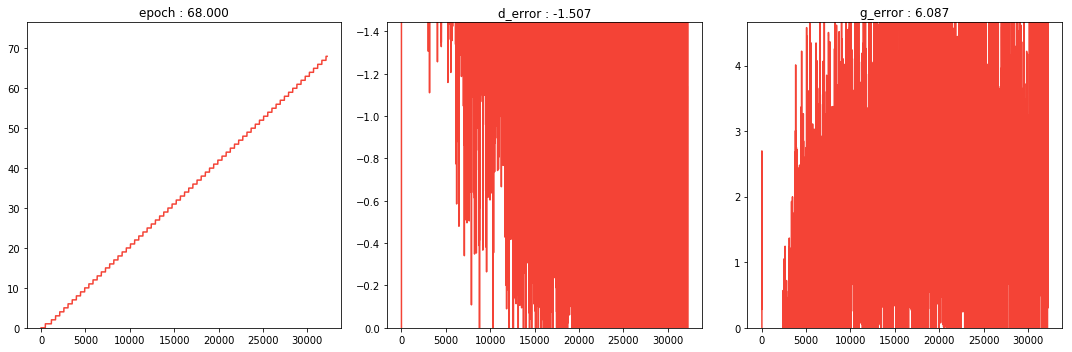

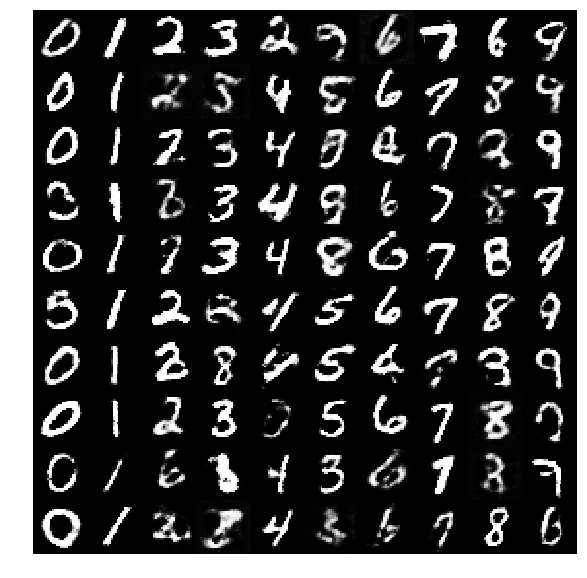

In [28]:
gen_steps = 1
gen_train_freq = 8
try:
    while True:
        for n_batch, (real_batch,label_batch) in enumerate(data_loader):
            #one hot labels
            label_batch = oneHot(label_batch[:,None],10).float().to(device)
            N = real_batch.size(0)
            # 1. Train Discriminator
            real_data = images_to_vectors(real_batch).to(device)
            # Generate fake data and detach 
            # (so gradients are not calculated for generator)
            noise_tensor = noise(N,noise_dim)
            random_labels = torch.randint(10, size=(N,1) ).long()
            random_labels = oneHot(random_labels,10).float().to(device)
            with torch.no_grad():
                fake_data = generator(torch.cat([noise_tensor,random_labels],1)).detach()
            # Train D
            d_error = train_discriminator(d_optimizer, real_data,label_batch, fake_data,random_labels)

            if global_step % gen_train_freq == 0:
                for _ in range(gen_steps):
                    # 2. Train Generator
                    # Generate fake data
                    noise_tensor = noise(N,noise_dim)
                    random_labels = torch.randint(10, size=(N,1) ).long()
                    random_labels = oneHot(random_labels,10).float().to(device)
                    fake_data = generator(torch.cat([noise_tensor,random_labels],1))
                    # Train G
                    g_error = train_generator(g_optimizer, fake_data,random_labels)
                    g_error = g_error.item()
            # Log batch error
            dis.update(global_step,'train',{"epoch":epoch,"d_error":d_error.item(),"g_error":g_error} )
            global_step+=1
            del fake_data
            del real_data
            del noise_tensor
            # Display Progress every few batches
            if global_step % 50 == 0:
                labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
                labels = oneHot(labels[:,None],10).float().to(device)
                test_images = vectors_to_images(generator(torch.cat([test_noise,labels],1)))
                test_images = test_images.data
                L = 28
                canvas = np.zeros((L*m,L*m))
                q = 0
                for i in range(m):
                    for j in range(m):
                        canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
                        q+=1
                dis.display(scale=True)
                plt.figure(figsize=(10,10))
                plt.imshow(canvas,cmap='gray')
                plt.axis("off")
                plt.show()
        epoch+=1
except:
    labels = torch.from_numpy(np.asarray([[k for k in range(m)] for _ in range(m)]).flatten())
    labels = oneHot(labels[:,None],10).float().to(device)
    test_images = vectors_to_images(generator(torch.cat([test_noise,labels],1)))
    test_images = test_images.data
    L = 28
    canvas = np.zeros((L*m,L*m))
    q = 0
    for i in range(m):
        for j in range(m):
            canvas[i*L:(i+1)*L,j*L:(j+1)*L] = test_images[q]
            q+=1
    dis.display(scale=True)
    plt.figure(figsize=(10,10))
    plt.imshow(canvas,cmap='gray')
    plt.axis("off")
    plt.savefig("Conditional-WGAN-GP-MNIST.png")
    plt.show()

## Conclusion

By adding the one-hot-encoded MNIST label both to the generator $G$ and the decoder $D$ we have built a generative model conditionned on this label. Thus by sampling random noise $z$ and selecting a label we can generate different digitis corresponding to this label.